# 2. Data exploration & Baseline model generation


In the previous notebook, two types of data were loaded to a PostGIS database called 'carto':
<br>
<br>

    * the NY census block geometries (geometries assigned with Polygon datatype)
    * NY taxi trip from Jan,Apr,Jul 2015(geometry data types not yet assigned)

<br>

Current schema of the database is as shown in the below diagram.

![](./tables.png)

<br>

The main tasks to be handled in this notebook are:

1. Merge the taxi and ACS dataset by block group to compute the average number of pickups by block group

2. Train a baseline model (nothing too fancy) using as covariates the ACS variables.

<br>


As to answer these questions, I will explore the data together in following order:

1. Assign geometry to sampled NY taxi pickup points (30,000 rows) using a query.

2. Three GeoDataFrames will be created: pickup points, census blocks, ACS data

3. Data will be either spatially joined or merged by pandas method to compute the total number of taxi pickups within each census block.

4. A linear regression will be used as a baseline model to train the data and get the first insight on how demographic and socio-economic factors drive the number of pickups by block group.

In [1]:
# import libraries
import numpy as np
import psycopg2
import pandas as pd
import geopandas as gpd
import contextily as ctx
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('Set2')
sns.despine()
sns.set_context(rc={'axes.labelsize':18,
                    'axes.titlesize':18,
                    'font.size':15,
                    'legend.fontsize':15,
                    'lines.linewidth':2.2})

/opt/conda/lib/python3.8/site-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  warnings.warn(


<Figure size 432x288 with 0 Axes>

# 2-1. EDA

### Prepare data

Let's take pickup-related variables only (pickup time, pickup point) from database.

A query will select pickup points from 'taxi_x' table **only if the points is within any census blocks**.
<br>(Tables in DB: 'taxi_jan', 'taxi_apr', 'taxi_jul')

The result will be limited to 10,000 rows per table (= per month) to reduce the size of the result table.

In [2]:
# Function to retrieve data from database using queries
# and save the result as a gdf (geodataframe)

def get_gdf(query, geom):
    # Connect to the database
    con =  psycopg2.connect(dbname='carto', user='carto', password='carto',
                            host='postgis', port='5432')

    # Save the query result as a geodataframe
    gdf = gpd.read_postgis(query, con, geom_col=geom)
    
    # Close connection
    con.close()
    return gdf

In [3]:
# Query to select 10,000 pickup data from each taxi table.
# Geometric Point will be created from longitude & latitude.
# ***Points within census block geometry polygons will be selected.***

tablenames = ['taxi_jan', 'taxi_apr', 'taxi_jul']
result_list = []

# iter tablenames
for i, tablename in enumerate(tablenames):
    query = f'''
            with

                pickups as
                (
                    select
                        tpep_pickup_datetime as pickup_time,
                        ST_SetSRID(ST_MakePoint(pickup_longitude, pickup_latitude), 4326)
                        as pickup_point
                    from {tablename}
                )

            select pickups.*, census.geoid
            from pickups, census_blocks as census
            where ST_Contains(census.geometry, pickups.pickup_point)
            LIMIT 10000;
            '''
    
    # Append the query results to a list
    i = get_gdf(query, 'pickup_point')
    result_list.append(i)

# Save the query results as a geodataframe
pickup_points = gpd.GeoDataFrame(pd.concat(result_list, ignore_index=True),
                                 geometry='pickup_point',
                                 crs=4326)

print(pickup_points.shape)
pickup_points.head()

(30000, 3)


,pickup_time,pickup_point,geoid
0,2015-01-14 12:07:28,POINT (-73.96980 40.76173),360610112032
1,2015-01-14 12:07:28,POINT (-73.97918 40.78690),360610171003
2,2015-01-14 12:07:28,POINT (-73.96611 40.76469),360610120002
3,2015-01-14 12:07:29,POINT (-73.97552 40.75595),360610094001
4,2015-01-14 12:07:29,POINT (-74.01387 40.71406),360610317032


In [4]:
# General information
pickup_points.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   pickup_time   30000 non-null  datetime64[ns]
 1   pickup_point  30000 non-null  geometry      
 2   geoid         30000 non-null  object        
dtypes: datetime64[ns](1), geometry(1), object(1)
memory usage: 703.2+ KB


In [5]:
# Change the data type of 'geoid' column
# object -> numeric
pickup_points.geoid = pd.to_numeric(pickup_points.geoid)
print(pickup_points.geoid.dtype)

int64


**Note**:
* There are 30,000 records in this table without null values.
* The datatype for each column is correctly assigned.

Data from 62 days


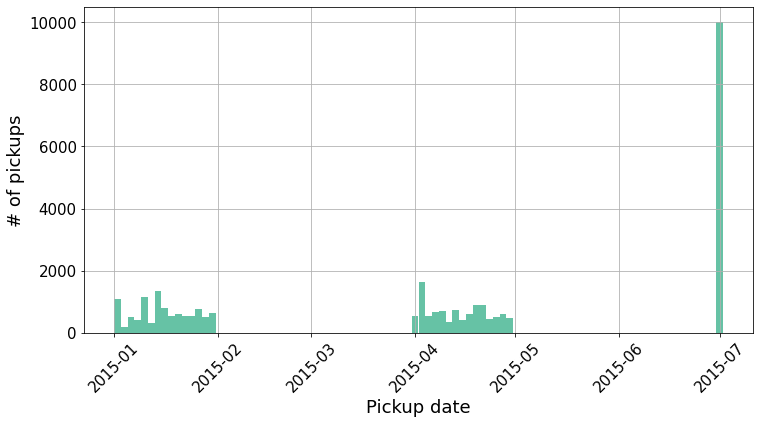

In [6]:
# Check the distribution of 'pickup_time' variable.
dates_from_pickup_points = pickup_points.pickup_time.dt.date

print(f'Data from {len(dates_from_pickup_points.unique())} days')

dates_from_pickup_points.hist(bins=90, figsize=(12,6))
plt.ylabel('# of pickups')
plt.xlabel('Pickup date')
plt.xticks(rotation=45)
plt.show()

**Note**:
    
* The sample data we have was collected from 1st of January to 1st of July. Data from January and April were collected from all around the month, but July's data was exclusively from the first day of the month.

In [7]:
# How many taxi pickups are in each geoid (=census block)?
n_pickups = pickup_points.groupby('geoid') \
                         .pickup_point \
                         .count() \
                         .sort_values(ascending=False)

# Result as DataFrame
n_pickups = pd.DataFrame(n_pickups)

# Rename the column name as 'n_pickups'
n_pickups = n_pickups.rename(columns={'pickup_point':'n_pickups'})

n_pickups.head()

,n_pickups
geoid,
360810716001,633
360610101001,628
360810331001,587
360610092001,423
360610099001,386


**Note:**
    
'n_pickups' from this table represents number of taxi pickups within each census block group ('geoid').

This 'n_pickups' column can be our target for the modeling.

[]

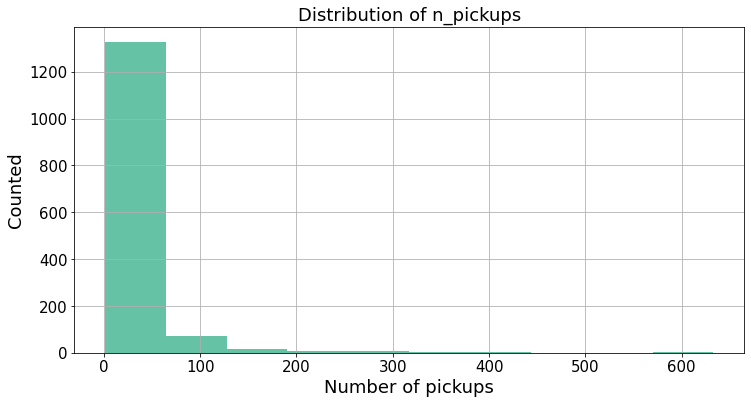

In [8]:
# Plot distribution of 'n_pickups'
n_pickups.hist(figsize=(12,6))
plt.title('Distribution of n_pickups')
plt.xlabel('Number of pickups')
plt.ylabel('Counted')
plt.plot()

In [9]:
# Summary statistics of 'n_pickups' column
n_pickups.describe()

,n_pickups
count,1435.000000
mean,20.905923
std,47.428551
min,1.000000
25%,1.000000
50%,6.000000
75%,20.000000
max,633.000000


**Note:**

Average n_pickups from the sample data is around 20 with high standard deiviation of 47.4, while the half of the population in this data have equal to or less than 6 taxi pickups (skewed data).

In [10]:
# Get top 10 geoid having the highest pickup numbers
top_10_pickups_idx = n_pickups[:10].index
top_10_pickups_idx = pd.to_numeric(top_10_pickups_idx).values
top_10_pickups_idx

array([360810716001, 360610101001, 360810331001, 360610092001,
       360610099001, 360610113001, 360610143001, 360610094001,
       360610125001, 360610102001])

# Visualize the data

Prepare the census block group geomteries to plot together with pickup points.

In [11]:
# Load NYC census block group geometries to draw polygons
census = gpd.read_file('../data/nyc_cbg_geoms.geojson')

# Sanity check: Are there missing or duplicated values?
print(f'How many rows with missing values?: {census.isnull().any().sum()}')
print(f'How many duplicated rows?: {census.duplicated().sum()}')
print(f'How many blocks are there?: {len(census.geoid.unique())}')

How many rows with missing values?: 0
How many duplicated rows?: 0
How many blocks are there?: 6339


In [12]:
# Are all data types are correctly assigned?
census.dtypes

geoid         object
geometry    geometry
dtype: object

In [13]:
# Change the data type of 'geoid' column
# object -> numeric
census.geoid = pd.to_numeric(census.geoid)
print(census.geoid.dtype)

int64


Visualize all the pickup points on top of the census block polygons.

In [14]:
# Print the current CRS (Coordinate Reference System)
print(f'Before: {pickup_points.crs}, {census.crs}')

# Reproject data in Web mercator
pickup_points = pickup_points.to_crs(epsg=3857)
census = census.to_crs(epsg=3857)
print(f'After: {pickup_points.crs}, {census.crs}')

Before: epsg:4326, epsg:4326
After: epsg:3857, epsg:3857


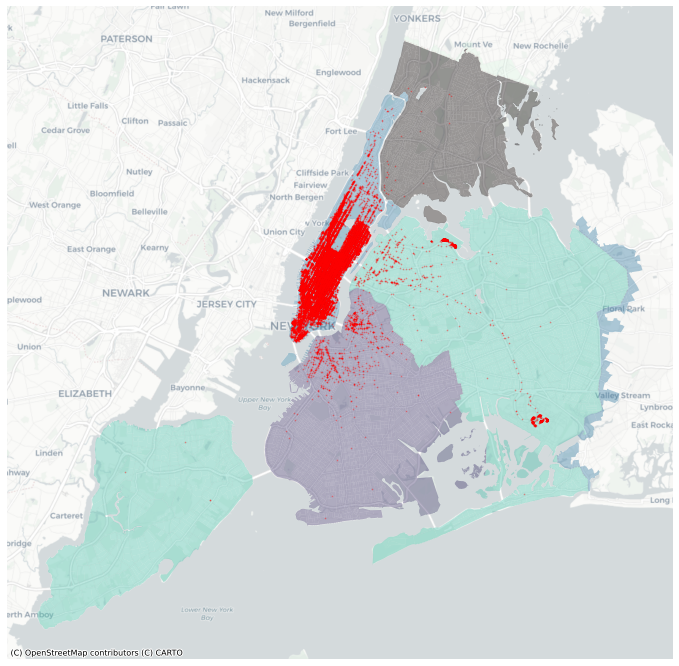

In [15]:
# Plot the census blocks (polygons)
ax = census.plot(column = 'geoid', figsize=(12, 12),
                 scheme='EqualInterval', alpha=.4, cmap='mako')

# Plot pickup points within blocks (red points)
pickup_points.plot(ax=ax, color='red', alpha=.3, markersize=.6)

# Basemap of NY city
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

ax.set_axis_off()
plt.show()

**Note**:
* The pickup points (red points) are heavily concentrated in Manhattan area.

**Visualize the top 10 pickup blocks**

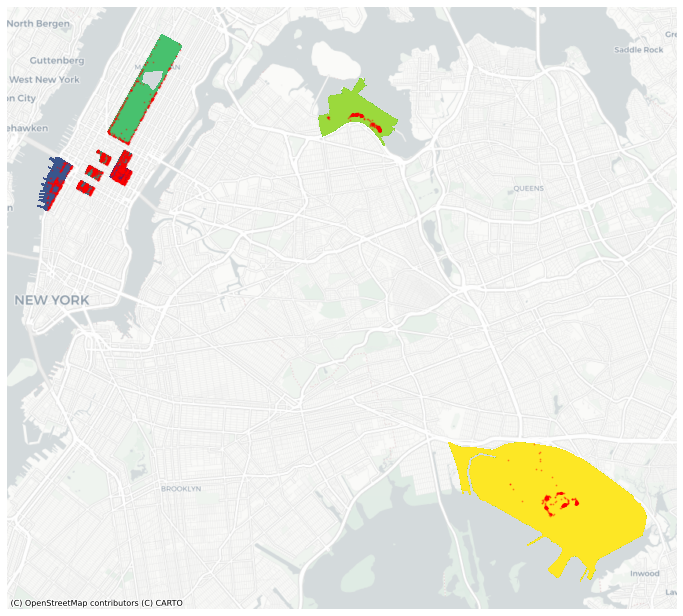

In [16]:
# Visualize 10 census blocks with highest taxi pickups
# using geoindex of top 10 pickup points: top_10_pickups_idx

# Select pickup points within top 10 blocks using geoid
top_10_pickup_points = pickup_points.set_index('geoid') \
                                    .loc[top_10_pickups_idx]

# Plot 10 census blocks with highest taxi pickups (use sjoin)
top_10_blocks = gpd.sjoin(census,
                           top_10_pickup_points,
                           how='inner',
                           op='contains') \

ax = top_10_blocks.plot(figsize=(12,12), cmap='viridis')

# Plot pickup points only within these top 10 blocks (red points)
top_10_pickup_points.plot(ax=ax, color='red', alpha=.3, markersize=1)

# Basemap of NY city
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

ax.set_axis_off()
plt.show()

### Load more data:

Get New york's demographic & socio-economic (by census block group) dataset (.csv file). First, clean the data and then use the data to compare the top 10 pickup points with the rest of the pickup data.

In [17]:
# Read the demographic and socio-economic data (by block group)
# from the American Community Survey (ACS) dataset
acs = pd.read_csv('../data/nyc_acs_demographics.csv', index_col=0)
print(acs.shape)
acs.head()

(199630, 3)


,geoid,acs_demog_var,value
0,360050001001,total_pop,7080.0
1,360050001001,two_or_more_races_pop,41.0
2,360050001001,vacant_housing_units_for_rent,0.0
3,360050001001,unemployed_pop,0.0
4,360050001001,black_pop,3984.0


In [18]:
# Let's pivot the demographic table for convinience
acs = acs.pivot_table(values='value',
                      index='geoid',
                      columns='acs_demog_var')

print(acs.shape)
acs.head()

(6339, 33)


acs_demog_var,aggregate_travel_time_to_work,amerindian_pop,asian_pop,black_pop,commuters_16_over,commuters_by_public_transportation,employed_pop,families_with_young_children,family_households,female_pop,...,other_race_pop,owner_occupied_housing_units_median_value,pop_16_over,renter_occupied_housing_units_paying_cash_median_gross_rent,total_pop,two_or_more_races_pop,unemployed_pop,vacant_housing_units,vacant_housing_units_for_rent,white_pop
geoid,,,,,,,,,,,,,,,,,,,,,
360050001001,NaN,25.0,125.0,3984.0,0.0,0.0,0.0,0.0,0.0,577.0,...,38.0,NaN,7080.0,NaN,7080.0,41.0,0.0,0.0,0.0,538.0
360050002001,NaN,0.0,0.0,468.0,608.0,271.0,608.0,63.0,356.0,1024.0,...,0.0,384200.0,1543.0,1793.0,1919.0,0.0,168.0,30.0,0.0,13.0
360050002002,NaN,0.0,0.0,238.0,579.0,161.0,588.0,96.0,363.0,773.0,...,86.0,415300.0,1423.0,1358.0,1703.0,0.0,118.0,71.0,15.0,52.0
360050002003,NaN,0.0,104.0,202.0,382.0,108.0,382.0,33.0,239.0,481.0,...,0.0,374700.0,718.0,1677.0,920.0,0.0,9.0,57.0,0.0,12.0
360050004001,NaN,0.0,24.0,24.0,213.0,69.0,259.0,0.0,136.0,227.0,...,0.0,363900.0,417.0,1375.0,468.0,0.0,0.0,15.0,15.0,0.0


In [19]:
# Remove if there's any empty row
acs.reset_index(inplace=True)
acs = acs[~acs.isnull()]
print(acs.shape)

(6339, 34)


In [20]:
# Remove if there's any duplicated row
acs = acs[~acs.duplicated()]
print(acs.shape)

(6339, 34)


In [21]:
# Total number of unique census blocks
len(acs.geoid.unique())

6339

In [22]:
# Are all data types are correctly assigned?
acs.dtypes

acs_demog_var
geoid                                                            int64
aggregate_travel_time_to_work                                  float64
amerindian_pop                                                 float64
asian_pop                                                      float64
black_pop                                                      float64
commuters_16_over                                              float64
commuters_by_public_transportation                             float64
employed_pop                                                   float64
families_with_young_children                                   float64
family_households                                              float64
female_pop                                                     float64
hispanic_pop                                                   float64
households                                                     float64
housing_units                                                  

**Note**:

All data types are numeric, which is good for using these fields as features for a linear regression model. Now, Let's merge this acs data to the n_pickup data.

### Merge the n_pickups and acs data

In [23]:
# Reset index of 'n_pickups' to merge on a 'geoid' column
n_pickups.reset_index(inplace=True)

# Change the data type of 'geoid' column
# object -> numeric
n_pickups.geoid = pd.to_numeric(n_pickups.geoid)
n_pickups.geoid.dtype

dtype('int64')

In [24]:
# Merge two dataframes
df = acs.merge(n_pickups, on='geoid')
print(df.shape)
df.head()

(1435, 35)


,geoid,aggregate_travel_time_to_work,amerindian_pop,asian_pop,black_pop,commuters_16_over,commuters_by_public_transportation,employed_pop,families_with_young_children,family_households,...,owner_occupied_housing_units_median_value,pop_16_over,renter_occupied_housing_units_paying_cash_median_gross_rent,total_pop,two_or_more_races_pop,unemployed_pop,vacant_housing_units,vacant_housing_units_for_rent,white_pop,n_pickups
0,360050019001,35695.0,0.0,57.0,541.0,843.0,573.0,852.0,220.0,381.0,...,NaN,1255.0,1260.0,1702.0,35.0,90.0,43.0,21.0,163.0,2
1,360050019003,NaN,0.0,17.0,374.0,334.0,264.0,334.0,19.0,74.0,...,393300.0,661.0,1451.0,902.0,20.0,89.0,21.0,0.0,88.0,1
2,360050023002,NaN,0.0,0.0,174.0,126.0,96.0,126.0,36.0,122.0,...,NaN,306.0,442.0,453.0,10.0,25.0,0.0,0.0,1.0,1
3,360050051001,NaN,0.0,0.0,163.0,111.0,84.0,111.0,27.0,67.0,...,NaN,245.0,NaN,332.0,0.0,78.0,26.0,0.0,0.0,4
4,360050063001,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,2


In [25]:
top_10_df = df.set_index('geoid').loc[top_10_pickups_idx]
top_10_df.describe()

,aggregate_travel_time_to_work,amerindian_pop,asian_pop,black_pop,commuters_16_over,commuters_by_public_transportation,employed_pop,families_with_young_children,family_households,female_pop,...,owner_occupied_housing_units_median_value,pop_16_over,renter_occupied_housing_units_paying_cash_median_gross_rent,total_pop,two_or_more_races_pop,unemployed_pop,vacant_housing_units,vacant_housing_units_for_rent,white_pop,n_pickups
count,3.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,5.000000e+00,10.000000,7.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.00000,10.000000
mean,51431.666667,2.300000,228.300000,46.300000,685.500000,294.200000,743.200000,31.800000,155.600000,443.500000,...,6.947198e+05,929.200000,3162.571429,987.600000,22.900000,32.300000,158.300000,35.100000,586.30000,420.100000
std,55239.208071,7.273239,362.265112,101.237949,1270.129849,544.990479,1342.797561,60.049609,280.650514,799.963645,...,5.260063e+05,1655.658164,275.211953,1781.856909,46.249204,65.804508,162.827823,47.603571,1082.89212,142.366077
min,16790.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.999000e+03,0.000000,2599.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,278.000000
25%,19580.000000,0.000000,0.500000,0.000000,9.250000,1.750000,12.500000,0.000000,1.000000,9.000000,...,4.667000e+05,15.000000,3114.000000,15.750000,0.000000,0.000000,3.000000,0.000000,4.25000,305.000000
50%,22370.000000,0.000000,33.000000,1.500000,66.000000,25.000000,70.000000,8.500000,9.000000,38.000000,...,7.344000e+05,96.500000,3250.000000,105.000000,5.500000,3.000000,136.000000,9.500000,54.00000,365.000000
75%,68752.500000,0.000000,360.750000,23.750000,793.000000,392.000000,881.750000,35.250000,195.000000,511.250000,...,8.125000e+05,1158.500000,3350.000000,1198.500000,22.000000,28.500000,309.750000,72.250000,596.25000,546.000000
max,115135.000000,23.000000,1140.000000,322.000000,4112.000000,1749.000000,4334.000000,196.000000,903.000000,2580.000000,...,1.450000e+06,5341.000000,3361.000000,5759.000000,150.000000,209.000000,344.000000,111.000000,3484.00000,633.000000


In [26]:
rest_indx = [i for i in df.geoid if i not in top_10_pickups_idx]
rest_df = df.set_index('geoid').loc[rest_indx]
rest_df.describe()

,aggregate_travel_time_to_work,amerindian_pop,asian_pop,black_pop,commuters_16_over,commuters_by_public_transportation,employed_pop,families_with_young_children,family_households,female_pop,...,owner_occupied_housing_units_median_value,pop_16_over,renter_occupied_housing_units_paying_cash_median_gross_rent,total_pop,two_or_more_races_pop,unemployed_pop,vacant_housing_units,vacant_housing_units_for_rent,white_pop,n_pickups
count,124.000000,1425.000000,1425.000000,1425.000000,1425.000000,1425.000000,1425.000000,1425.000000,1425.000000,1425.000000,...,9.200000e+02,1425.000000,1348.000000,1425.000000,1425.000000,1425.000000,1425.000000,1425.000000,1425.000000,1425.000000
mean,38194.314516,1.673684,185.697544,166.783860,721.134737,472.059649,787.505965,83.990175,279.215439,726.679298,...,1.057435e+06,1200.870175,1916.917656,1393.098246,35.752281,44.510877,96.955789,22.402807,700.946667,18.104561
std,27451.674593,10.448955,261.533983,298.044805,451.970660,337.724792,480.050173,94.524987,182.586333,414.187714,...,5.258734e+05,653.063172,719.793262,762.374553,49.239095,49.713025,115.354474,39.702464,551.705864,31.784269
min,6450.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.999000e+03,0.000000,260.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,22923.750000,0.000000,41.000000,0.000000,459.000000,268.000000,512.000000,20.000000,163.000000,467.000000,...,6.749750e+05,800.000000,1411.500000,922.000000,0.000000,9.000000,25.000000,0.000000,323.000000,1.000000
50%,32862.500000,0.000000,101.000000,36.000000,648.000000,424.000000,707.000000,61.000000,255.000000,654.000000,...,9.275500e+05,1117.000000,1883.000000,1278.000000,19.000000,32.000000,66.000000,0.000000,619.000000,5.000000
75%,42182.500000,0.000000,223.000000,174.000000,891.000000,596.000000,973.000000,122.000000,354.000000,890.000000,...,1.375000e+06,1448.000000,2393.250000,1703.000000,52.000000,64.000000,130.000000,33.000000,960.000000,20.000000
max,195980.000000,224.000000,3268.000000,2058.000000,6483.000000,4849.000000,6767.000000,1030.000000,2250.000000,5037.000000,...,2.000001e+06,7881.000000,3501.000000,8830.000000,426.000000,395.000000,1513.000000,467.000000,6111.000000,271.000000


In [27]:
# Population density of the top 10 pickup blocks?

# Merge census block geometry with acs data
top_10_merged = top_10_blocks.merge(top_10_df, on='geoid')

# Compute population denstiy
top_10_merged['pop_density'] = top_10_merged['asian_pop'] / top_10_merged.area

# Set index, remove duplicated row, print the result
top_10_merged.set_index('geoid', inplace=True)
remove_duplicates = ~top_10_merged['pop_density'].duplicated()
top_10_density = top_10_merged['pop_density'][remove_duplicates]
top_10_density

geoid
360610092001    0.001143
360610094001    0.000015
360610099001    0.000652
360610101001    0.001365
360610102001    0.000007
360610113001    0.000202
360610125001    0.001250
360610143001    0.000000
Name: pop_density, dtype: float64

In [28]:
# Population density of the rest of the blocks?

# Merge census block geometry with acs data
rest_merged = census.merge(rest_df, on='geoid')

# Compute population denstiy
rest_merged['pop_density'] = rest_merged['asian_pop'] / rest_merged.area

# Set index, remove duplicated row, print the result
rest_merged.set_index('geoid', inplace=True)
remove_duplicates = ~rest_merged['pop_density'].duplicated()
rest_density = rest_merged['pop_density'][remove_duplicates]
rest_density[:10]

geoid
360050019001    0.000127
360050019003    0.000023
360050023002    0.000000
360050063006    0.000077
360050183022    0.000220
360050217004    0.000810
360050224011    0.001283
360050281001    0.000906
360050289003    0.000406
360050378002    0.000521
Name: pop_density, dtype: float64

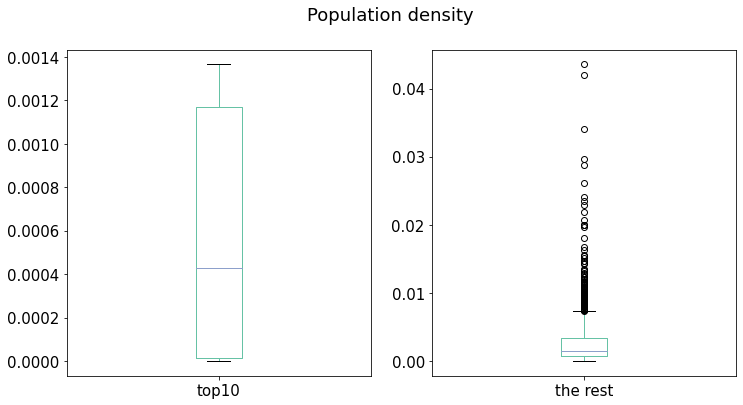

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
top_10_density.plot(kind='box', label='top10', ax=ax[0])
rest_density.plot(kind='box', label='the rest', ax=ax[1])

plt.suptitle('Population density')
plt.show()

# 2-2. Modeling


* Train a baseline model for the n_pickups using ACS variables as covariates.
* What is the performance of the model?
* What can we learn from this model?


Since the **target (n_pickup) is a continuous variable**, I'll use **linear regression** as a baseline model.

Columns from the acs table will be used as features, n_pickups will be the target.

### Check linearity by using:
* Scatterplot of variables
* Correlation coefficient

In [30]:
# Set 'geoid' as index
df.set_index('geoid', inplace=True)

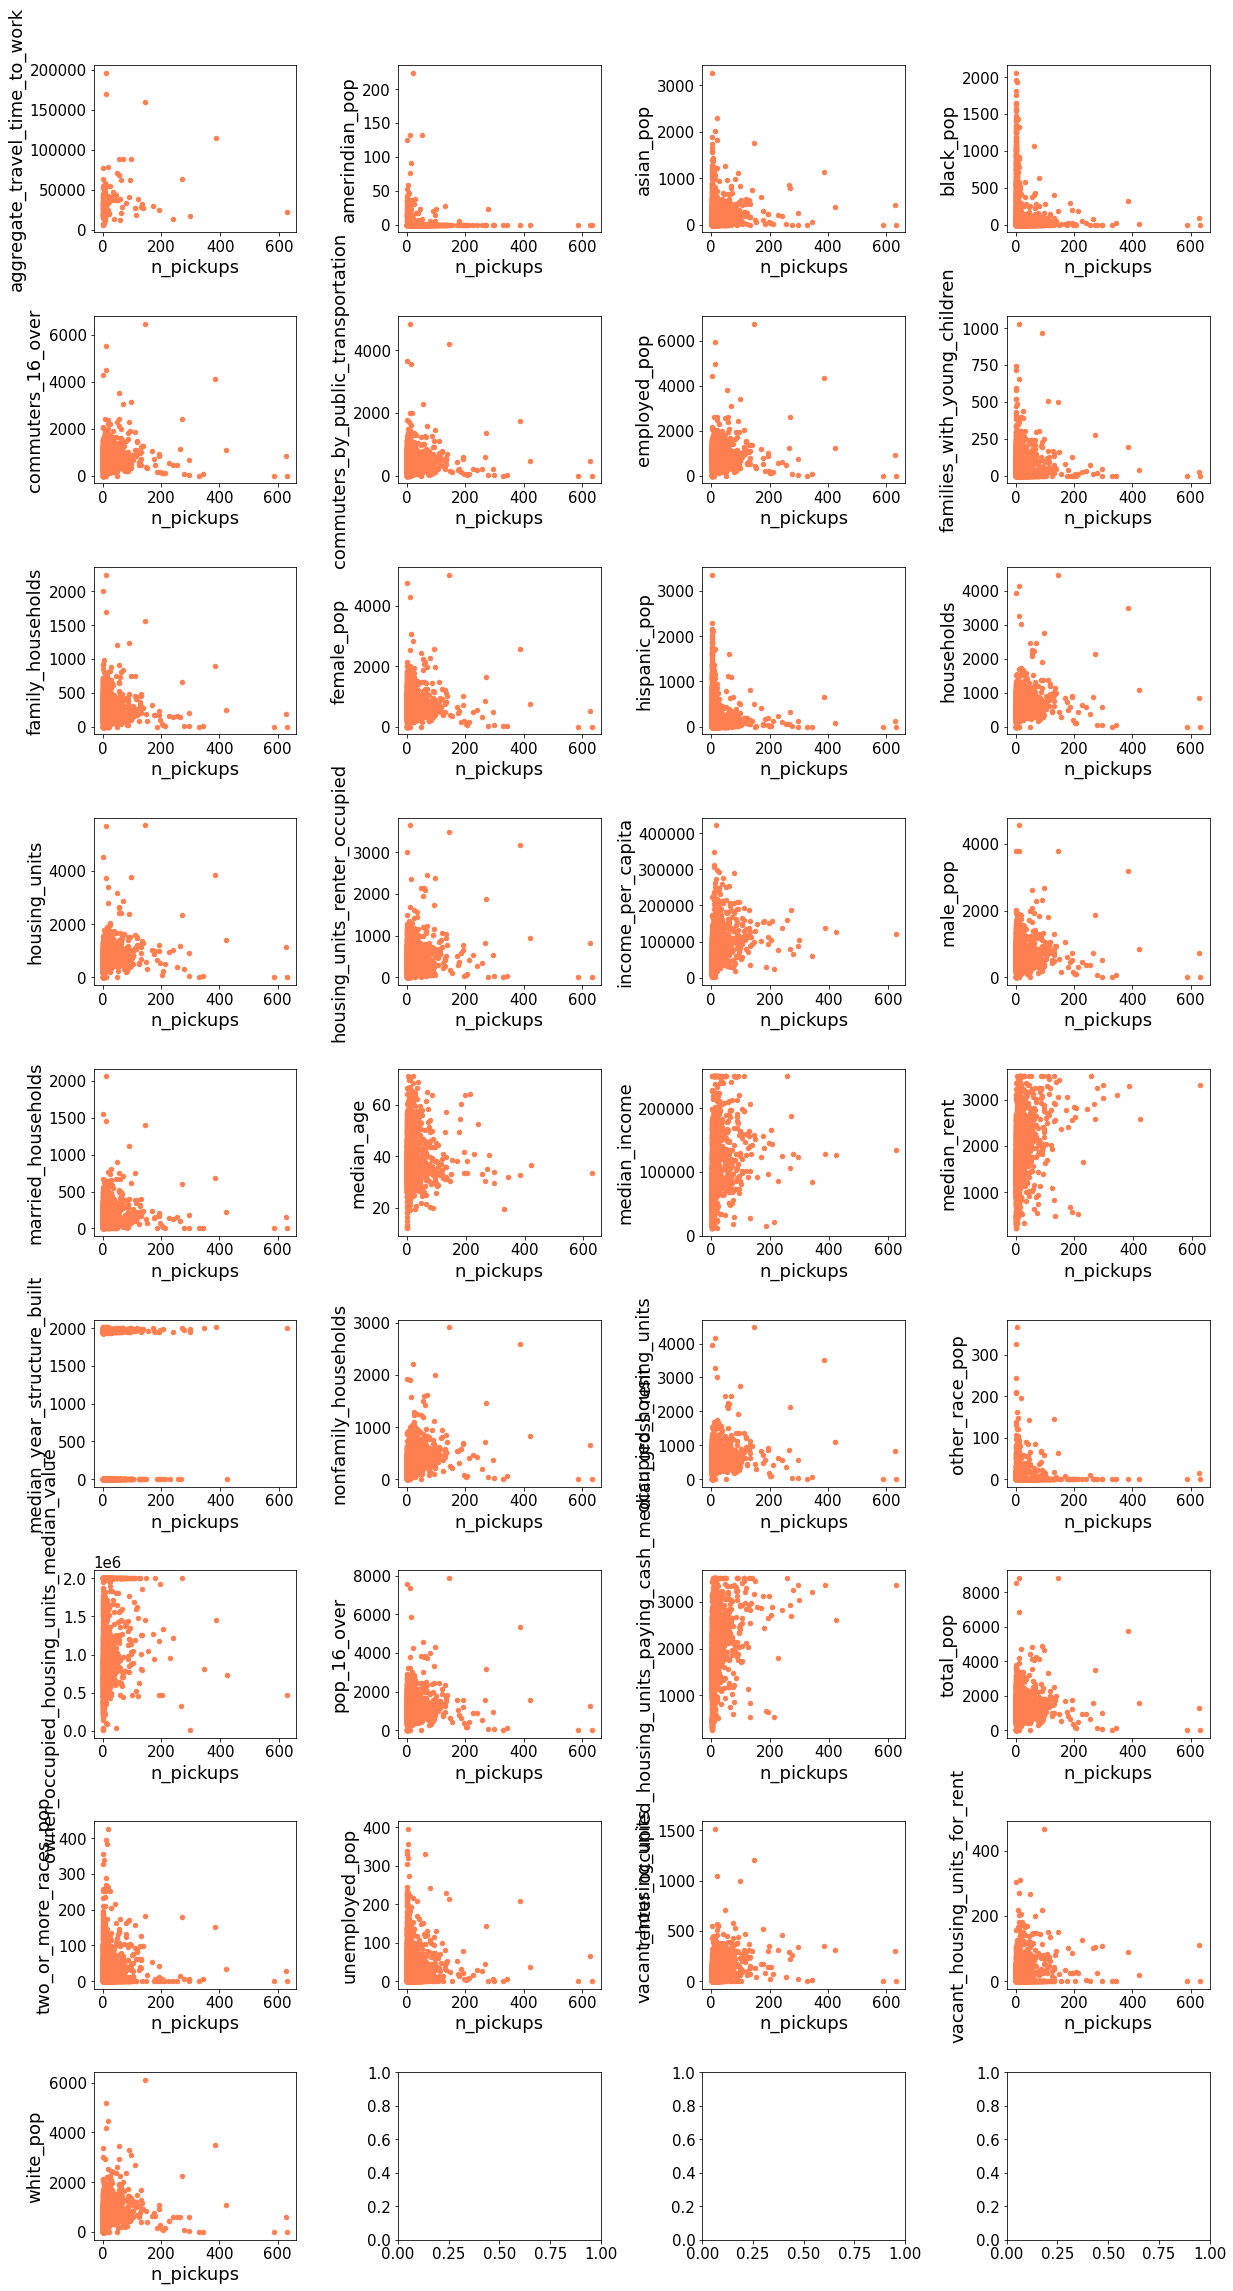

In [34]:
# Scatterplot of variables to check for linearity
fig, ax = plt.subplots(9, 4, figsize=(20,40))
plt.subplots_adjust(hspace=.5, wspace=.5)

cols_to_plot = [col for col in df.columns if col != 'n_pickups']
for i, variable in enumerate(cols_to_plot):
    df.plot('n_pickups',
            variable,
            kind='scatter',
            color='coral',
            ax=ax[int(i/4), (i%4)])

plt.show()

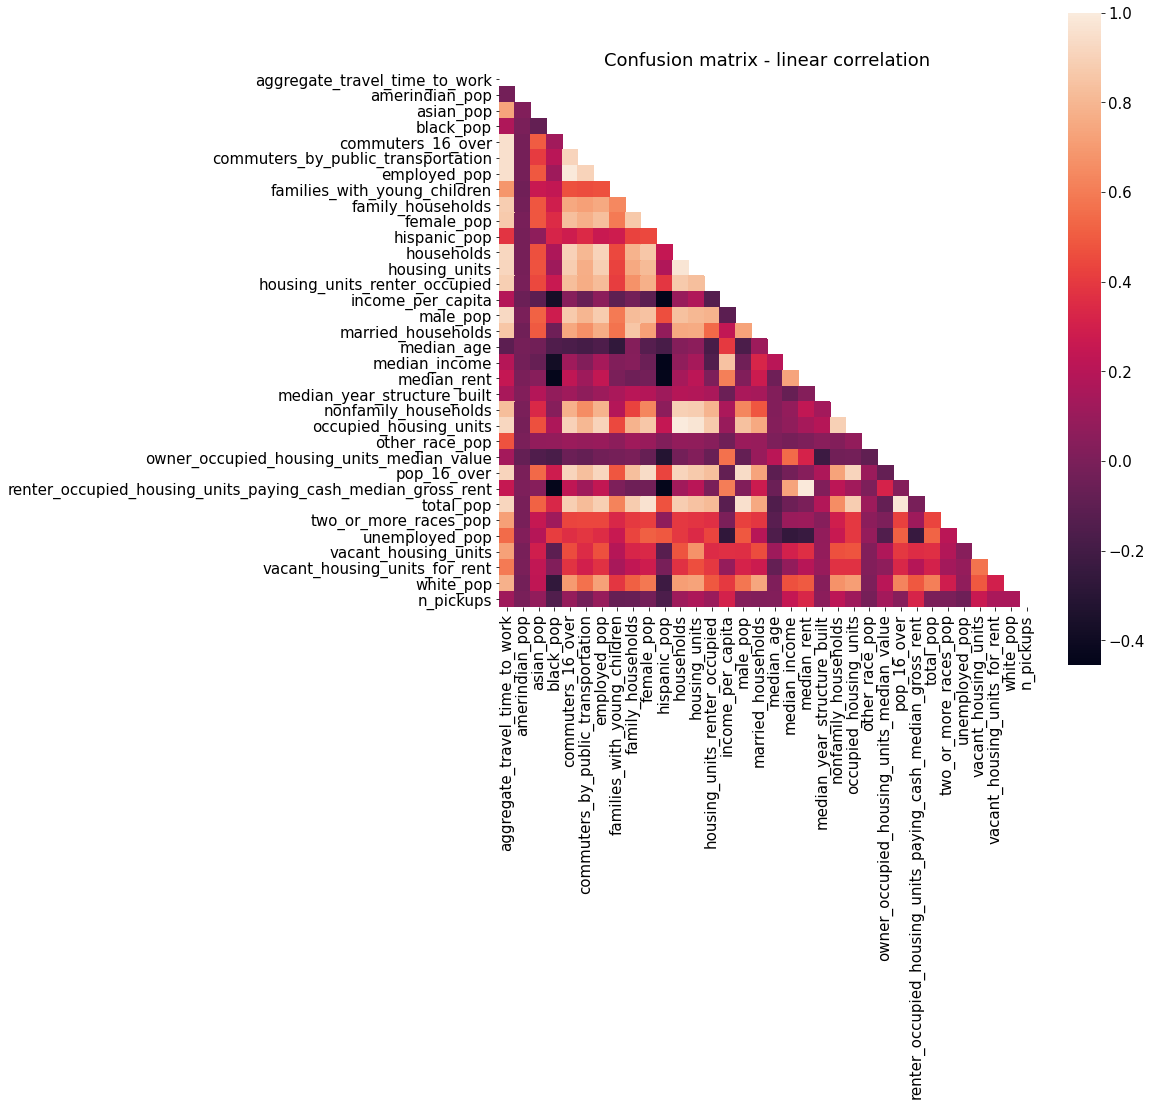

In [35]:
# Calculate correlation coefficient
corr = df.corr()

# Confusion matrix
plt.figure(figsize=(12,12))
matrix = np.triu(corr)
sns.heatmap(corr, fmt='.1g', square=True, mask=matrix)
plt.title('Confusion matrix - linear correlation')
plt.show()

### Feature selection

Based on the scatterplot and correlation coefficient, I will manually selected some features that looks like to have some linear relationship with the target.

In [36]:
# Select features relatively correlated (r > 0.09) with the target only
select_highly_correlated = abs(corr['n_pickups']) > 0.09
features = corr[select_highly_correlated]['n_pickups'].index
features = [feat for feat in features if feat != 'n_pickups']

In [37]:
# Are there any missing values within the selected features?
print(f'Is there any missing value?: {bool(df[features].isnull().any().sum())}')

Is there any missing value?: True


In [38]:
# Which features have missing rows and how many?
df[features].isnull().mean()

aggregate_travel_time_to_work                                  0.911498
black_pop                                                      0.000000
employed_pop                                                   0.000000
hispanic_pop                                                   0.000000
households                                                     0.000000
housing_units                                                  0.000000
housing_units_renter_occupied                                  0.000000
income_per_capita                                              0.013937
median_income                                                  0.096167
median_rent                                                    0.058537
nonfamily_households                                           0.000000
occupied_housing_units                                         0.000000
owner_occupied_housing_units_median_value                      0.355401
renter_occupied_housing_units_paying_cash_median_gross_rent    0

**Note**

* 'aggregate_travel_time_to_work' feature misses almost 90% of the data -> REMOVE
* Other features with missing values -> Let's try simple inputation

In [39]:
# 1. Remove 'aggregate_travel_time_to_work' column
print(len(features))
features = [feat for feat in features if feat != 'aggregate_travel_time_to_work']
print(len(features))

17
16


In [40]:
# Initiate SimpleImputer. Methods to inpute: most_frequent values
my_imputer = SimpleImputer(strategy='most_frequent')

# Redefine df using selected features and column.
columns = features + ['n_pickups']

# Impute missing values of the reduced df.
df = pd.DataFrame(my_imputer.fit_transform(df[columns]), columns=columns)

In [41]:
# Check if imputation worked
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1435 entries, 0 to 1434
Data columns (total 17 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   black_pop                                                    1435 non-null   float64
 1   employed_pop                                                 1435 non-null   float64
 2   hispanic_pop                                                 1435 non-null   float64
 3   households                                                   1435 non-null   float64
 4   housing_units                                                1435 non-null   float64
 5   housing_units_renter_occupied                                1435 non-null   float64
 6   income_per_capita                                            1435 non-null   float64
 7   median_income                                                1435 non-null   f

In [42]:
# Define target
target = 'n_pickups'

### Split the data into train & test set to measure model performance

In [43]:
# train_test split
X_train, X_test, y_train, y_test = train_test_split(df[features], # X
                                                    df[target],   # y
                                                    test_size=0.3,
                                                    shuffle=True)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1004, 16)
(431, 16)
(1004,)
(431,)


### Fit a linear regression model using train data

In [44]:
# Train model
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

### Evaluate the model performance using test data

In [45]:
# Predict on test set
y_pred = lr.predict(X_test) # use the predict method of the object

In [46]:
# Evaluate the performance using MAE
MAE = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error:', round(MAE, 2))

Mean Absolute Error: 20.45


**Note**

The number of taxi pickups (target) was predicted by using a subset of ACS fields that has a certain degree of linear relationship with the target.

I chose **MAE (Mean Absolute Error) as an evaluation metric** since it is intuitively easy to understand how far our predictions are off from true values.

MSE (Mean Squared Error) can be also considered if the model requires higher penalization on wrong predictions far off the mark.

The MAE from current model is around 20.5, which means that our prediction on the number of taxi pickups within a census block can be wrong by 20-21 taxi trips in average.

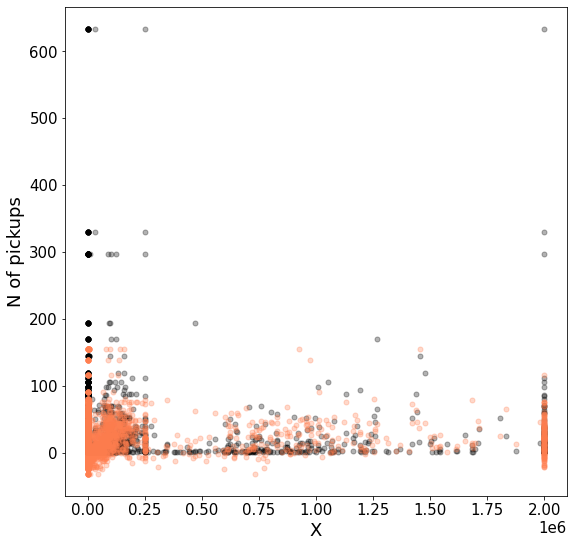

In [47]:
# Plot the true values (y_test) and predicted values (y_pred) together.
fig, ax = plt.subplots(figsize=(9,9))
ax.plot(X_test, y_test, 'black', marker='o',
        markersize=5, alpha=.3, linewidth=0)
ax.plot(X_test, y_pred, 'coral', marker='o',
        markersize=5, alpha=.3, linewidth=0)

plt.xlabel('X')
plt.ylabel('N of pickups')
plt.show()

### Discussion - How can we improve the model performance?

Firstly, we can improve the current features by using different data preprocessing methods such as outlier identification, missing value imputation, or aggregation.

Secondly, we can bring additional features that might be strongly correlated to the target variable. One example would be adding calendar attributes of the pickup dates (month / week of month / weekday / hour) or area of each block as input for the algorithm. Another example is to add more location information using open data source such as [New York City Borough Boundaries data](https://geo.nyu.edu/catalog/nyu-2451-34510) or Open Street Map's geodata that can be extracted with QGIS.

Finally, we can try different machine learning models such as Decision tree regressor or ensemble learning models like XGBoost.

-------------------------------
# End of notebook